# 모델 훈련

선형 모델을 훈련시키는 두 가지 방법은 다음과 같다. 선형 모델을 훈련시키는 방법(배깅, 부스팅, 결정 트리 등등)은 이것보다 더 많다.

**정규방정식**은 직접 계산할 수 있는 공식을 사용하여 훈련 세트에 가장 잘 맞는 모델 파라미터를 해석적으로 구한다.  
$\hat{\theta} = {(X^TX)}^{-1}X^Ty$  
  
비용 함수 $J(SSE)$에 대한 각 파라미터의 편미분이 0이 되는 연립방정식을 구한 후, $X^TX$의 역행렬이 존재하는 상황에서 연립방정식을 행렬로 나타내면 위 식을 바로 구할 수 있다. $X^TX$의 역행렬이 존재하지 않는다면 정규방정식 말고 아래에 소개될 **SVD 방식**을 사용해야 한다.

**경사 하강법**(GD)으로 모델 파라미터를 조금씩 바꾸면서 훈련 세트에 대한 비용 함수를 최소화한다.

# 선형 회귀

## 정규방정식

선형처럼 보이는 데이터 생성

In [1]:
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

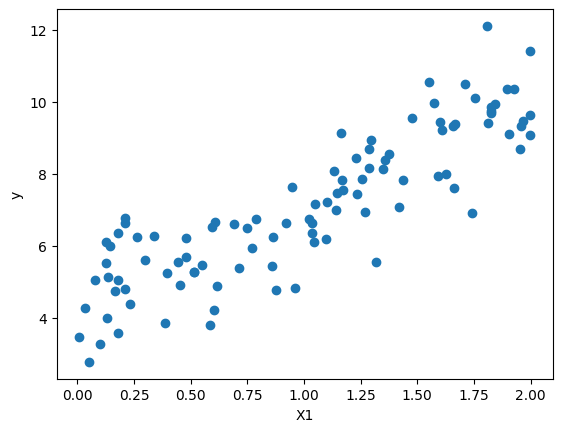

In [2]:
import matplotlib.pyplot as plt

plt.scatter(X, y)
plt.xlabel("X1")
plt.ylabel("y")
plt.show()

$\hat{\theta}$ 계산

In [3]:
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 x0 = 1 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

print("평균 제곱 오류를 최소로 하는 theta 값")
print(theta_best)
print("원래 theta 값")
print(np.array([[4], [3]]))

평균 제곱 오류를 최소로 하는 theta 값
[[4.15789109]
 [2.89424002]]
원래 theta 값
[[4]
 [3]]


모델의 예측을 그래프로 나타냄. 훈련 세트의 X에 대한 상한값과 하한값을 모델로 예측하여 그리면 됨.

In [4]:
X_new = np.array([[0], [2]]) # 훈련 세트의 X에 대한 상한값(0)과 하한값(2)
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.15789109],
       [9.94637113]])

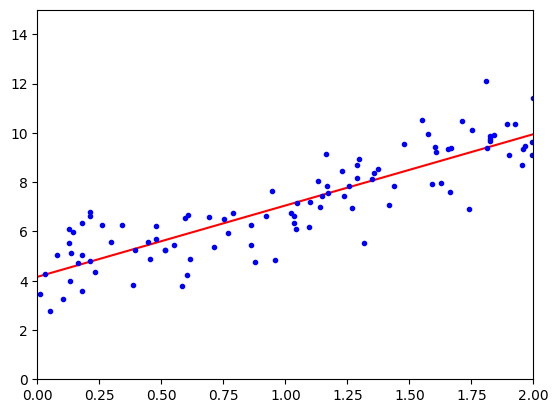

In [5]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

## SVD 방식

사이킷런으로 선형 회귀를 실행

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [7]:
lin_reg.intercept_, lin_reg.coef_ # intercept_ 편향, coef_ 가중치

(array([4.15789109]), array([[2.89424002]]))

In [8]:
lin_reg.predict(X_new)

array([[4.15789109],
       [9.94637113]])

정규방정식은 $X^TX$의 **역행렬이 존재하지 않는다**면 값을 구할 수 없다. 따라서, 이 경우 **유사역행렬**($X^+=V{\Sigma}^+U^T$, 특이값 분해 SVD로 $U, \Sigma, V$를 구함)를 이용하여 $\hat{\theta} = X^+y$를 구해야 한다(SVD 방식은 특잇값 분해가 항상 가능하므로 항상 값을 구할 수 있다).

 **이 방식은 정규방정식을 포함하는 더 넓은 개념이다**. LinearRegression()가 intercept_(편향), coef_(가중치)을 구할 때 이 방식을 이용한다. 또한, 정규방정식을 이용하여 계산한 값이 SVD 방식을 이용하여 계산한 값과 동일하다.

정규방정식을 계산하는 것보다 **이 방식**이 **훨씬 더 효율적**이다. **극단적인 경우도 처리**할 수 있다.

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.15789109],
       [2.89424002]])

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.15789109],
       [2.89424002]])

## 계산 복잡도

**정규방정식**의 계산 복잡도는 *$O(n^{2.4})$에서 $O(n^3)$* 사이이다. **특성 수**가 2배 늘어나면 계산 시간이 대략 $2^{2.4}$=5.3에서 $2^3$=8배로 증가한다.

반면 **SVD 방식**은 약 $O(n^2)$이다. **특성 수**가 2배 늘어나면 계산 시간이 대략 4배 늘어난다.

**샘플 수**에 대해서는 **둘 다** 계산 복잡도가 $O(m)$이다.

**예측 계산 복잡도**는 **둘 다 특성 수와 샘플 수**에 대해 $O(m)$이다. 샘플이 두 배로 늘어나거나 특성이 두 배로 늘어나면 예측 계산 시간도 거의 두 배 증가한다.

다음 소개되는 **경사 하강법**은 특성이 매우 많고, 훈련 샘플이 너무 많아 메모리에 모두 담을 수 없을 때 적합하다.

# 경사 하강법

**경사하강법**은 파라미터마다 그레이디언트($\frac{\partial L}{\partial w}$)를 계산하고 이를 이용해 **비용 함수($L$)가 줄어들도록**(기울기 값($\frac{\partial L}{\partial w}$)에 적당한 학습률($\eta$)을 곱해 파라미터 값($w$)에서 빼면 비용 함수가 줄어듦, 아래 식 참고) **파라미터($w$)를 갱신**한다.  
  
$w = w - \eta \frac{\partial L}{\partial w}$

여기서 학습률($\eta$)가 중요하다. **학습률이 너무 작으면** 너무 많은 학습을 반복해야 해서 시간이 오래 걸리고, **학습률이 너무 크면** 비용 함수가 더 큰 값으로 발산하게 될 수 있어 비용 함수가 **극소값**(지역 최소값)에 다다르지 못할 수 있다.

MSE 비용 함수에 대한 경사 하강법

선형 회귀를 위한 **MSE 비용 함수**는 어떤 두 점을 선택해 선을 그어도 곡선을 가로지르지 않는 볼록 함수이다. 이는 최역 최솟값이 없고 하나의 전역 최솟값만 있다는 뜻이다. 또한, MSE는 연속 함수이고 기울기가 갑자기 변하지 않는다.  
  
이 두 사실로부터 **MSE 비용 함수에 대한 경사 하강법**이 전역 최솟값에 가깝게 접근할 수 있다는 것을 보장한다.

특성의 스케일

경사 하강법을 사용할 때 반드시 **모든 특성이 같은 스케일**(특성이 가지고 있는 값의 범위)을 **가지도록 만들어야 한다**(예를 들어 사이킷런의 StandardScaler). 그렇지 않으면 극소값으로 수렴하는데 훨씬 오래 걸린다.

## 배치 경사 하강법

**활성 함수가 없다**고 할 때 **비용 함수의 편도함수**는  
$\frac{\partial}{\partial \theta_j}MSE(\theta) = \frac{2}{m}\overset{m}{\underset{i=1}{\Sigma}}(\theta^Tx^{(i)} - y^{(i)})x_j^{(i)}$ 이고,
  
각 비용 함수의 편도함수를 벡터로 모은 **비용 함수의 그레이디언트 벡터**는  
$\nabla_\theta MSE(\theta) = \begin{pmatrix} \frac{\partial}{\partial \theta_0}MSE(\theta) \\ \frac{\partial}{\partial \theta_1}MSE(\theta) \\ \vdots \\ \frac{\partial}{\partial \theta_n}MSE(\theta) \end{pmatrix} = \frac{2}{m}X^T(X\theta - y)$ 이다.  
  
따라서, 출력과 비용 함수 사이에 **활성 함수가 추가된다면 비용 함수의 편도함수나 그레이디언트 벡터는 달라질 수 있다**.

배치 경사 하강법은 **전체 훈련 세트**에 대해 계산한다.  
**경사 하강법은 특성 수에 민감하지 않아** 수십만 개의 특성에서 선형 회귀를 훈련시키려면 앞서 말한 **정규방정식이나 SVD 분해보다 경사 하강법을 사용하는 편이 훨씬 빠르다.**

경사 하강법의 스텝

$\theta^{(next\ step)} = \theta - \eta\nabla_\theta MSE(\theta)$

In [11]:
eta = 0.1
n_iterators = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterators):
    gradient = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradient

print(theta)

[[4.15789109]
 [2.89424002]]


학습률을 달리한 후 최적점을 찾아가는 선형 회귀 그래프 보기

In [12]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")    # 훈련 세트 산점도
    
    n_iterations = 1000     # 1000번 반복 훈련
    for iteration in range(n_iterations):
        
        # 초반 10번 선형 모델(직선) 그리기
        if iteration < 10:                         
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        
        # 파라미터 조정
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        
        # 조정되는 파라미터를 모두 리스트에 저장 (theta_path=None 옵션이 아닌 경우)
        if theta_path is not None:
            theta_path.append(theta)
            
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

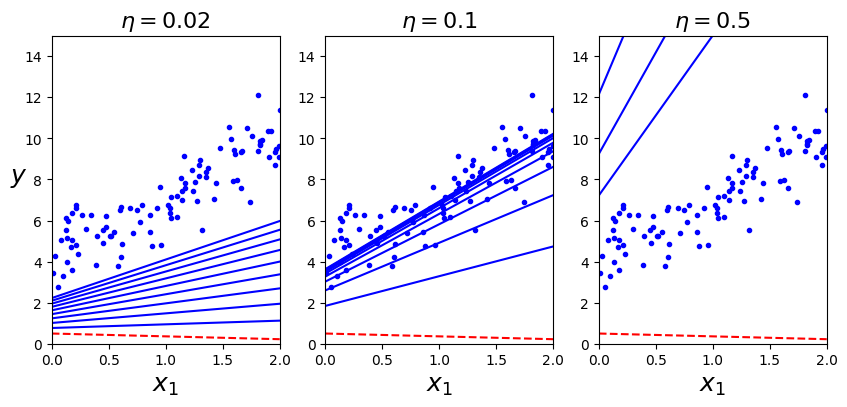

In [13]:
np.random.seed(42)
theta = np.random.randn(2,1)  # 무작위 초기화

plt.figure(figsize=(10,4))    # 도표 크기 지정

# eta=0.02
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)

# eta=0.1
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)

# eta=0.5
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

그리드 탐색으로 적절한 학습률 찾기

적절한 학습률을 찾으려면 그리드 탐색을 사용한다. 그리드 탐색에서는 수렴하는 데 너무 오래 걸리는 모델을 막기 위해 반복 횟수를 제한할 수 있다. 이때, 반복 횟수를 너무 작게 설정하면 최적점에 도달하기 전에 학습이 멈추고, 반복 횟수를 너무 크게 설정하면 모델 파라미터가 더 이상 변하지 않는 시간 동안 시간을 낭비하게 된다.  
그리드 탐색을 이용하여 **최적의 학습률**을 찾는 괜찮은 방법은 **반복 횟수를 아주 크게 설정하고 그레이디언트 벡터가 아주 작아지면**(벡터 노름이 어떤 $\epsilon$(허용 오차)보다 작아지면) **경사 하강법이 (거의) 최소값에 도달한 것으로 보고 알고리즘을 중지하는 것**이다.

허용 오차에 따른 알고리즘 반복 횟수

비용 함수가 **볼록 함수이고 기울기가 급격하게 바뀌지 않는 경우 학습률을 고정**한 배치 경사 하강법은 결국 **최적의 솔루션에 도달한다.**  
비용 함수에 따라 다르지만 $\epsilon$ **범위 안에서** 최적의 솔루션에 도달하기 위해서는 $O(1/\epsilon)$**의 반복**이 걸릴 수 있다. 허용 오차 $\epsilon$를 1/10로 줄이면 알고리즘의 반복은 10배 늘어난다.

## 확률적 경사 하강법

확률적 경사 하강법은 배치 경사 하강법보다 **빠르지만** 위 아래로 요동치면서 평균적으로 감소하므로 **불안정하다**. 그렇기 때문에 최솟값에 다다르지 못한다. 하지만 불안정하기 때문에 얻어지는 장점도 있다. 이러한 불안정은 (convex 하지 않은) 함수의 지역 최소값으로부터 탈출하는 데 도움을 줄 수 있기 때문이다.  
  
확률적 경사 하강법이 (전역 최소값이 아닌 )지역 **최소값을 탈출하면서 전역 최소값에 도달하게 하는 방법은 학습률을 점차 줄이는 것이다**. 처음에는 지역 최소값을 쉽게 벗어나도록 학습률을 큰 값으로 설정했다가, 시간이 지날수록 학습률을 점차 줄여 전역 최소값에 도달할 수 있도록 한다. 여기서 학습률을 조절하는 함수를 **학습 스케줄**(learning schedule)이라고 한다.  
  
학습률이 너무 빨리 줄어들면 지역 최소값에 갇히거나 전역 최소값에 도달하기 전에 중간 지점에서 멈출 수 있다. 학습률이 너무 천천히 줄어들면 전역 최소값 주변을 맴돌거나 지역 최소값에 머무를 수 있다. 따라서, **학습률은 너무 빨리 혹은 너무 천천히 줄어들지 않도록 적당히 줄어들도록 해야 한다.**

In [14]:
theta_path_sgd = []

n_epochs = 50
t0, t1, = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index: random_index+1]
        yi = y[random_index: random_index+1]
        gradients = 2*xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch*m + i)
        theta = theta - eta*gradients
        theta_path_sgd.append(theta)

print(theta)

[[4.12512333]
 [2.89158891]]


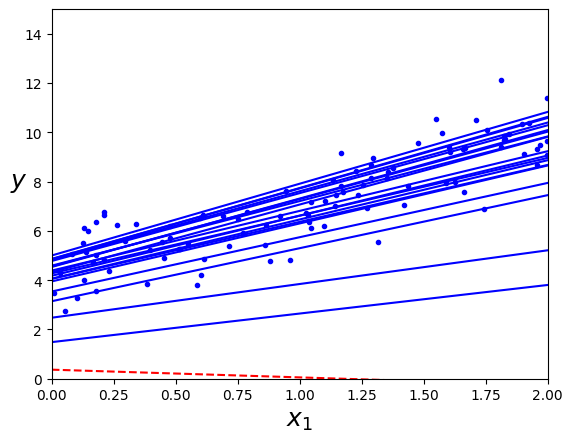

In [15]:
theta = np.random.randn(2,1)    # 파라미터 랜덤 초기화

for epoch in range(n_epochs):
    
    # 매 샘플에 대해 그레이디언트 계산 후 파라미터 업데이트
    for i in range(m):
        
        # 처음 20번 선형 모델(직선) 그리기
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
            
        # 파라미터 업데이트
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)  # 하나의 샘플에 대한 그레이디언트 계산
        eta = learning_schedule(epoch * m + i)        # 학습 스케쥴을 이용한 학습률 조정
        theta = theta - eta * gradients

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
plt.show()        

훈련 세트의 모든 샘플 활용

위 2개의 코드 셀과 같이 무작위로 **복원 추출**을 사용한다면 어떤 샘플은 중복하여 선택되고, 또 다른 어떤 샘플은 전혀 선택되지 않을 수 있다. 모든 샘플을 사용하게 하려면 무작위로 **비복원 추출**을 사용하면 되는데 그렇게 하면 모든 샘플이 선택된다.  
  
여기서 주의할 점은 결과적으로 선택된 샘플들의 특성이나 레이블이 **순서대로 나열되어 있다면 제대로 학습이 되지 않으므로(최적점에 도달하지 못한다) 정렬되지 않도록 순서를 잘 섞어야 한다**(ex. a,a,a,a,b,b,b보다는 a,b,a,b,a,b,a가 더 잘 학습된다). **iid(독립 항등 분포)를 만족해야 평균적으로 파라미터가 전역 최적점을 향해 진행한다고 보장**할 수 있다  
  
당연한 말이지만 훈련 세트의 특성 X와 훈련 세트의 레이블 y는 선택되는 순서가 같아야 한다. 즉, X\[2\]가 선택되었는데 y\[3\]가 선택되면 안 되고 y\[2\]가 선택되어야 한다.

In [16]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1) # tol은 tolerance of loss, 허용 오차, penalty는 규제
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [17]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.20861651]), array([2.96807574]))

### 학습 스케줄, learning rate

**optimal**, 이론적으로 안정적인 학습률을 보인다. $\eta{(t)} = \frac{1}{alpha(t_0 + t)}$가 optimal의 학습 스케줄이다.  
$alpha$ 규제 강도에 따라 알고리즘이 달라질 수 있으며, $t_0$은 $alpha$와 비용 함수에 따라 결정된다.  
  
**invscaling**, 사용자 정의적인 측면이 있다. $\eta^{(t)} = \frac{eta0}{t^{power_t}}$이 invscaling의 학습 스케줄이다.  
$\eta^{(t)} = \frac{eta0}{t^{power_t}}$에서 $eta0,\ power_t$을 바꿀 수 있어 이 값들을 바꿔 학습 스케줄을 조정할 수 있다.  

---

아래 코드는 invscaling으로 학습률이 어떻게 변화하는지, 학습률 감소율이 어떻게 변화하는지 보여준다. eta0, power_t는 default 값(각각 0.01, 0.25)이다.

첫 번째 그래프는 eta가 시간에 따라 변화되는 그래프이고, 두 번째 그래프는 eta의 감소율이 시간에 따라 변화되는 그래프인데 time=10 이후로 부터는 급격히 감소되는 정도가 작아진다

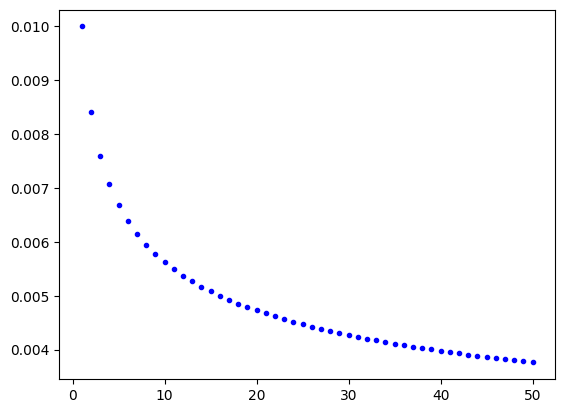

In [18]:
eta0 = 0.01
power_t = 0.25
time = [i+1 for i in range(50)]
eta = [eta0 / t**power_t for t in time]
plt.plot(time, eta, 'b.')

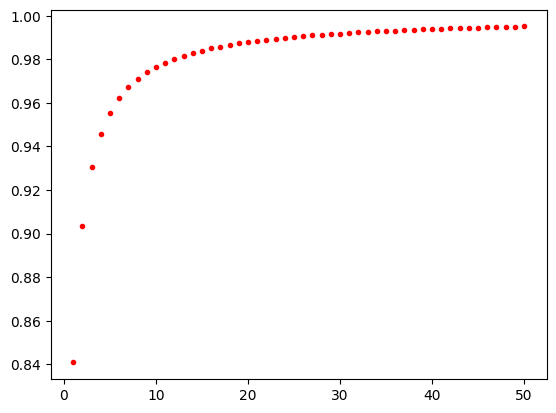

In [19]:
eta_decrease_rate = [(1-1/(t+1))**power_t for t in time]
plt.plot(time, eta_decrease_rate, 'r.')

## 미니 배치 경사 하강법

미니 배치 경사 하강법으로 학습

In [20]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

print(theta)

[[4.27926111]
 [3.04278722]]


In [21]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

배치 경사 하강법(BGD), 확률적 경사 하강법(SGD), 미니 배치 경사 하강법(MBGD)에 따른 $\theta$(가중치, $\theta_1$, 편향, $\theta_0$) 변화

**벡터 연산**을 하는 확률적 경사 하강법과는 달리 **행렬 연산**을 하는 배치 경사 하강법이나 미니 배치 경사 하강법은 행렬 연산에 최적화된 하드웨어(GPU, TPU 등)를 사용해서 성능을 향상시킬 수 있다.  
  
배치 경사 하강법, 미니 배치 경사 하강법, 확률적 경사 하강법 순으로 $\theta$가 더 불규칙하게 움직인다. $\theta$가 **더 불규칙적으로 움직일수록 지역 최소값에서 더 잘 빠져 나온다**. 반면, $\theta$가 **더 규칙적으로 움직일수록 전역 최소값에 더 가까워진다**. 또한, 지역 최소값이 2개 이상이 되는 경우 **지역 최소값에서 더 벗어나기 어려워진다**(지역 최소값이 전역 최소값이 아닌 경우 비용 함수의 최소값을 찾지 못할 수 있다).  
  
이때, $\eta$를 조절하여 불규칙하게 움직이는 것을 조절할 수 있는데 **$\eta$가 커진다면 불규칙성이 더 늘어나고, $\eta$가 작아진다면 규칙성이 더 늘어난다.** 따라서, 상대적으로 불규칙적인 미니 배치 경사 하강법과 확률적 경사 하강법을 **적절한 학습 스케줄을 이용해 시간이 지남에 따라 $\eta$를 감소시켜 효과적으로 전역 최소값을 찾게 할 수 있다**. 처음에 상대적으로 큰 $\eta$ 들은 지역 최소값을 벗어나게 해주고, 이후의 상대적으로 작은 $\eta$ 들은 전역 최소값을 찾게 해준다.  

$\theta$의 규칙성, 불규칙성의 수학적 정의에 대한 아이디어

  
여기서 불규칙하게 움직인다는 것을 **수학적으로 정의**하면 좋은데, 지금 생각나는 아이디어는 이전 매개변수 변화 방향과 현재 매개변수 변화 방향의 각도가 180도에 가까울수록 불규칙한 것 같고, 또 하나 더 고려해야 할 것은 움직인 거리가 클수록 불규칙한 것 같다. 근데 경우에 따라 다르다. **방향의 변화가 거의 없는데 움직인 거리가 크면 규칙적**일 것이고, **방향의 변화가 매우 큰데 거리가 움직인 거리가 작아도 규칙적**일 것이다.  
  
**시간에 따라 변화의 방향과 길이는 다르지만 확실한 것은 지역 최소점을 찾기 위한 알고리즘을 반복하므로 어느 시점에서 지역 최소점(혹은 그 언저리)을 찾는다는 것**이다.

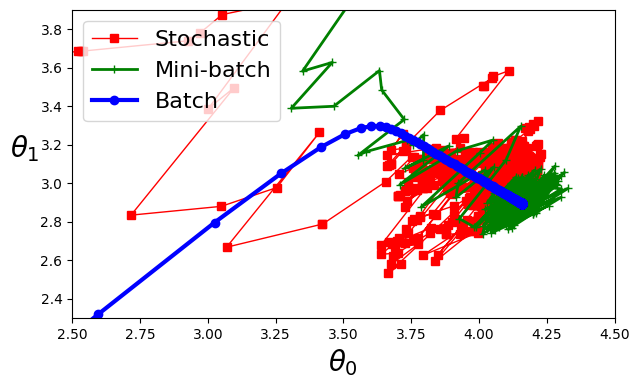

In [22]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

## 선형 회귀를 사용한 알고리즘 비교

| 알고리즘        | m이 클 때 | 외부 메모리 학습 지원 | n이 클 때 | 하이퍼 파라미터 수 | 스케일 조정 필요 | 사이킷런             |
| ----------- | ------ | ------------ | ------ | ---------- | --------- | ---------------- |
| 정규방정식       | 빠름     | No           | 느림     | 0          | No        | N/A              |
| SVD         | 빠름     | No           | 느림     | 0          | No        | LinearRegression |
| 배치 경사 하강법   | 느림     | No           | 빠름     | 2          | Yes       | SGDRegressor     |
| 확률적 경사 하강법  | 빠름     | Yes          | 빠름     | >=2        | Yes       | SGDRegressor     |
| 미니배치 경사 하강법 | 빠름     | Yes          | 빠름     | >=2        | Yes       | SGDRegressor     |

# 다항 회귀

## 선형 회귀 모델

선형 회귀 모델은 $X$ 특성이 독립변수, $y$ 레이블이 종속변수, $\theta_1$ 파라미터가 계수인 출력 함수가 직선($y = \theta_1^TX^1$)일 때의 모델을 말한다.  
  
여기서 X는 벡터이며, y는 스칼라, $\theta_d$는 d차항에 대한 계수를 가지는 벡터이다.  
  
$\theta_1$은 (사실 포함되면 안 되는) 0차항의 계수인 편향도 포함하는데 $X$에 $X_0=1$을 맨 앞에 추가하면 $\theta_1^TX$로 편향도 나타낼 수 있기 때문이다.  

## 다항 회귀 모델

다항 회귀 모델은 $y = \underset{d=1}{\overset{D}{\Sigma}} \theta^T_d X^d, \ D \ge 2$  
=> X가 행렬이라면 $\theta^T_d X^d$ 대신 $X^d \theta_d$로 표현될 것
  
여기서 $X^d$는 X의 d차인 특성 간의 모든 교차항(예를 들어, $a^2, b^2$ 뿐만 아니라 $ab$도 포함)을 포함한다.

## PolynomialFeatures

PolynomialFeatures(degree=d)는 X 특성을 이용하여 d차까지 특성 간의 모든 교차항을 추가한다.  
  
```python
from skleran.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False) # 개수는 $_{n+d}C_d$ - 1, include_bias=True 이어야 개수가 $_{n+d}C_d$
X_poly = poly_features.fit_transform(X)
```
  
추가되어진 X_poly 최종 특성은 $_{n+1}H_d = _{n+d}C_d = \frac{(n+d)!}{d!n!}$ 개의 원소를 가진다.  
  
이는 $_nH_r=_{n+r-1}C_r$와 $_{n+1}C_{r+1}=_nC_{r+1} + _nC_r$ 을 이용하여 $_{n+1}H_d=_nH_d+_{n+1}H_{d-1}$을 증명한 후,  
  
증명된 식을 이용하여 n개의 특성에서 0, 1, 2, 3, ..., d개를 중복으로 선택한 개수($_nH_0=_{n+1}H_0$, $_nH_1$, $_nH_2$, ..., $_nH_d$)를 모두 합하면 나오는 개수($_nH_0(=_{n+1}H_0) + _nH_1 + _nH_2 +  ...  + _nH_d = _{n+1}H_d = _{n+d}C_d = \frac{(n+d)!}{d!n!}$)이다.

참고로 $_nH_r=_{n+r-1}C_r$ 증명하는 방법은 작대기를 둬서 증명하는 방법과 중복으로 뽑인 수들을 작은 부터 큰 수까지 순서대로 나열하는데 0~r-1을 작은 수부터 큰 수까지 차례대로 더하는 방법이 있다.  
  
$_{n+1}C_{r+1}=_nC_{r+1} + _nC_r$를 증명하는 방법은 임의의 수 a를 결코 고르지 않다고 가정할 때 n+1개에서 r+1개를 고르는 개수($_nC_{r+1}$)와 a를 먼저 고른다고 가정할 때 n+1개에서 r+1개를 고르는 개수($_nC_r$)를 더한 값이 n+1개에서 r+1개를 고르는 개수와 같다는 식으로 증명하면 된다.

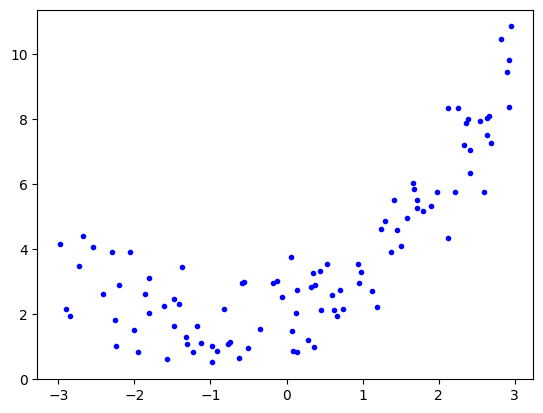

In [23]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5*X**2 + X + 2 + np.random.randn(m,1)
plt.plot(X, y, "b.")

In [24]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0], X_poly[0])

[2.38942838] [2.38942838 5.709368  ]


In [25]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

[1.9735233] [[0.95038538 0.52577032]]


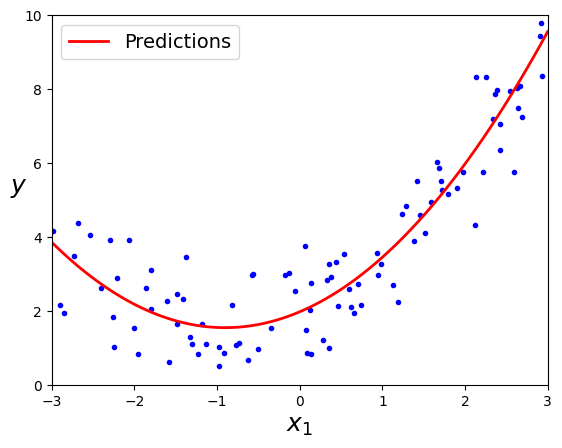

In [26]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

특성이 여러 개일 때 다항 회귀는 특성 간의 관계를 찾을 수 있다. 선형 회귀일 때에는 특성 간의 관계를 직선적(일차 결합, linear combination)으로 표현할 수 밖에 없지만 다항 회귀일 때에는 특성 간의 관계를 더 복잡하게 표현할 수 있다.

# 학습 곡선

모델이 데이터에 과소적합 혹은 과대적합 되었는지 알 수 있는 방법으로 **교차 검증을** 사용할 수 있다. 훈련 세트의 성능과 검증 세트의 성능이 모두 좋다면 잘 일반화된 것이고, 모두 안 좋다면 과소적합된 것이고, 훈련 세트의 성능은 좋은데 검증 세트의 성능은 안좋다면 과대적합된 것이라고 볼 수 있다.

또 다른 방법으로 **학습 곡선**을 사용할 수 있다. 학습 곡선은 훈련 세트의 크기를 독립변수로 하는 훈련 세트와 검증 세트의 성능(여기서는 RMSE, $\ell_2$ 값과 다름)그래프로 나타낸 것이다.

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # 책에는 없음
    plt.xlabel("Training set size", fontsize=14) # 책에는 없음
    plt.ylabel("RMSE", fontsize=14)              # 책에는 없음

## 과소적합

아래의 그래프는 전형적인 과소적합에 대한 학습 곡선 그래프이다. 과소적합된 모델은 데이터 세트를 거의 학습하지 못하기 때문에 훈련 세트가 늘어남에 따라 훈련 오차와 검증 오차가 꽤 높은 오차에서 매우 가까이 근접한다.  

모델이 훈련 데이터에 과소적합되었다면 훈련 샘플을 아무리 추가해도 모델 성능이 나아지지 않는다. 더 복잡한 모델을 사용하거나 더 나은 특성을 선택해야 한다.

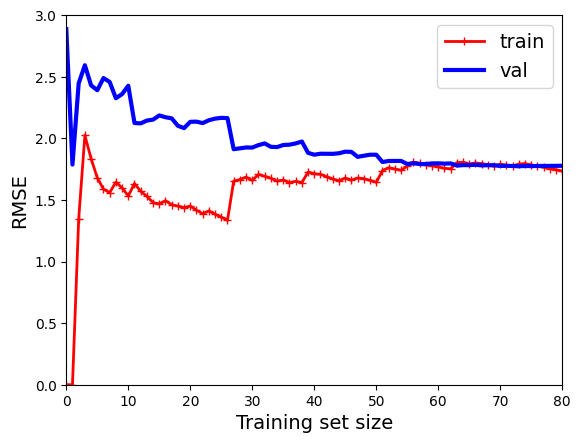

In [28]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, np.r_[X, X], np.r_[y, y]) # 깃헙 원본 np.r_[X, X]는 원래 X, np.r_[y, y]는 원래 y였음
plt.axis([0, 80, 0, 3])                         # 책에는 없음
plt.show()   

## 과대적합

과대적합된 모델의 훈련 오차는 훈련 세트에 과대적합되었기 때문에 과소적합된 모델의 훈련 오차보다 훨씬 낮다.

또한, 과대적합된 모델을 일반화를 잘 하지 못하므로 검증 오차는 훈련 오차보다 훨씬 크다. 즉, 검증 오차와 훈련 오차 간의 공간이 생긴다. 하지만, 점점 더 큰 훈련 세트를 사용하면 이 공간이 점점 줄어든다.

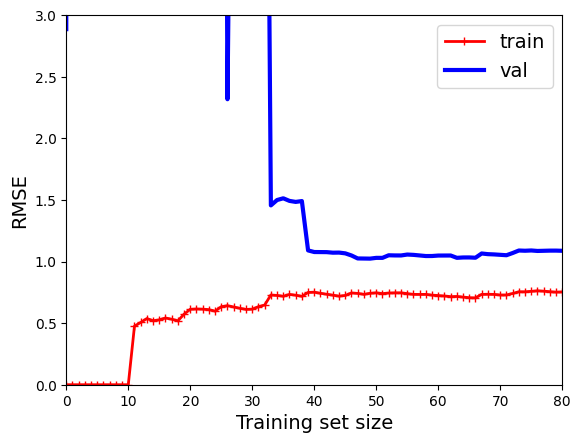

In [29]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, np.r_[X, X], np.r_[y, y]) # 깃헙 원본 np.r_[X, X]는 원래 X, np.r_[y, y]는 원래 y였음
plt.axis([0, 80, 0, 3])           # 책에는 없음
plt.show()  

## 편향/분산 트레이드오프

통계학과 머신러닝에서 나온 중요한 이론 하나는 '**모델의 일반화 오차는 편향($E[f^*(x)-f(x)]$), 분산($Var[f(x)]$), 줄일 수 없는 오차($\sigma^2$)의 합으로 표현할 수 있다'는 것이다**. 아래의 $Loss(MSE)$에 대한 방정식을 보면 이해할 수 있다.

$f^*$는 찾고자 하는 함수이고, $f$는 예측 모델이다. 또한, $\epsilon$는 정규분포$N(0,\sigma^2)$를 따르고, $y = f^*(x) + \epsilon$을 만족한다. $\epsilon$는 $y$(정답)의 잡음, 노이즈이다.
  
$Loss(MSE) = E[(y-f(x))^2] = \sigma^2 + Var[f(x)] + E[f^*(x)-f(x)]^2$  
  
여기서, $Var[f(x)]$는 f의 분산, $E[f^*(x)-f(x)]$는 f의 편향, $\sigma$는 $y$의 $\epsilon$(노이즈)의 표준편차이다.

### 증명

$E[X^2] = Var[X] + E[X]^2 \quad \cdots \quad (1)\\[10pt]
proof)\\[3pt]
E[X^2] = E[X^2] - E[2XE[X]] + E[2XE[X]] - E[E[X]^2] + E[E[X]^2]\\[3pt]
\qquad \quad = (E[X^2] - E[2XE[X]] + E[E[X]^2]) + (E[2XE[X]] - E[E[X]^2])\\[3pt]
\qquad \quad = E[X^2 - 2XE[X] + E[X]^2] + 2E[X]E[X] - E[X]^2\\[3pt]
\qquad \quad = E[(X-E[X])^2] +  2E[X]^2 - E[X]^2\\[3pt]
\qquad \quad = Var[X] +  E[X]^2$

---

$Var[y] = \sigma^2 \quad \cdots \quad (2)\\[10pt]
proof)\\
Var[y] = E[(y - E[y])^2]\\
\qquad \quad = E[(f^*(x) + \epsilon - E[f^*(x) + \epsilon])^2]\\
\qquad \quad = E[(f^*(x) + \epsilon - f^*(x) - E[\epsilon])^2]\\
\qquad \quad = E[\epsilon^2]\\
\qquad \quad = Var[\epsilon] + E[\epsilon]^2\\
\qquad \quad = \sigma^2$

---

$Loss(MSE) = E[(y-f(x))^2] = \sigma^2 + Var[f(x)] + E[f^*(x)-f(x)]^2\\[10pt]
proof)\\[3pt]
E[(y-f(x))^2] = E[y^2 -2yf(x) + f(x)^2]\\[3pt]
\qquad \qquad \qquad \ \ = E[y^2] + E[f(x)^2] - E[2yf(x)]\\[3pt]
\qquad \qquad \qquad \ \ = Var[y] + E[y]^2 + Var[f(x)] + E[f(x)]^2 - 2E[y]E[f(x)] \cdots (1)\\[3pt]
\qquad \qquad \qquad \ \ = Var[y] + Var[f(x)] + (E[y] - E[f(x)])^2\\[3pt]
\qquad \qquad \qquad \ \ = Var[y] + Var[f(x)] + (E[f^*(x) + \epsilon] - E[f(x)])^2\\[3pt]
\qquad \qquad \qquad \ \ = Var[y] + Var[f(x)] + (E[f^*(x) - f(x)] + E[\epsilon])^2\\[3pt]
\qquad \qquad \qquad \ \ = \sigma^2 + Var[f(x)] + (E[f^*(x) - f(x)])^2 \cdots (2)\\[3pt]$

**통상적으로 모델의 복잡도가 커지면($\uparrow$) 분산이 늘어나고($\uparrow$) 편향은 줄어든다는 것($\downarrow$)과 모델의 복잡도가 줄어들면($\downarrow$) 편향이 커지고($\uparrow$) 분산이 작아($\downarrow$)진다**는 것을 편향/분산 트레이드오프라고 부른다.

학습할 수 있는 파라미터가 더 많아지면 모델이 더 복잡하다고 볼 수 있다. 추후에 소개될 릿지 회귀와 라쏘 회귀는 규제($alpha$)가 강할수록 중요도가 낮은 혹은 임의의 파라미터를 0에 가깝게 만들어 모델을 단순화시킨다.  
  
여기서 중요한 것은 더 복잡한 모델을 사용하더라도 학습이 되지 않으면 데이터의 패턴을 학습하지 못하기 때문에 과소적합이 될 수 있다.

$Loss$에서 $\sigma$는 $y$(정답)의 노이즈를 줄이면 어느 정도 감소된다. 하지만 편향과 분산은 동시에 줄이기 어려우므로 **모델의 복잡도를 조절해가며 편향과 분산의 합이 최소가 되는 지점을 찾는 것**이 좋다.

# 규제가 있는 선형 모델

과대적합을 줄이는 방법은 모델을 규제하는 것이다.  
  
다항 회귀 모델을 규제하는 간단한 방법은 다항식의 차수를 감소시키는 것이다.  
**선형 회귀 모델**에서는 보통 가중치를 제한함으로써 규제를 가한다. 규제 방식은 '릿지 회귀', '라쏘 회귀', '엘라스틱넷'이 있다.

## 릿지(Ridge) 회귀

릿지 ridge 회귀(티호노프 Tikhonov 규제)는 비용 함수($J(\theta)$)에 규제항($\alpha \frac{1}{2} \overset{n}{\underset{i=1}{\Sigma}}\theta_i^2$, $l_2$ 노름)이 추가한다.  
$J(\theta) = MSE(\theta) + \alpha \frac{1}{2} \overset{n}{\underset{i=1}{\Sigma}}\theta_i^2(= \alpha \frac{1}{2} {(|| \theta ||_2)}^2)$  
이는 학습 알고리즘을 데이터에 맞추기 위해 모델의 가중치가 가능한 한 작게 유지되도록 한다.


훈련에 사용되는 목적 함수와 테스트에 사용되는 목적 함수가 다름

규제항은 훈련하는 동안에만 비용 함수에 추가된다. 모델의 훈련이 끝나면 모델의 성능을 규제가 없는 성능 지표로 평가한다. 참고로, 비용 함수, 성능 지표(정밀도, 재현율)이 목적 함수가 될 수 있는데, **목적 함수**는 손실을 최소화하기 위한 함수이거나 이익을 최대화하기 위한 함수이다.   
  
일반적으로 훈련하는 동안 사용되는 비용 함수와 테스트에서 사용되는 성능 지표는 다르다. 규제항을 떠나서 이들이 다른 이유는 비용 함수는 최적화를 위해 미분이 가능해야 하고, 성능 지표는 최종 목표에 가능한 한 가까워야 하기 때문이다.  
  
**예를 들어**, 로지스틱 회귀에서 소프트 맥스 함수(활성화 함수)와 교차 엔트로피 오차(비용 함수)를 따로 미분하지 않고 한 번에 미분해서 계산 과정을 한 번 줄일 수 있다. 또한, 로지스틱 회귀는 분류 모델이라서 성능 지표로 PR(정밀도, 재현율)을 사용하는데 이는 교차 엔트로피 오차와 다르다.

$\alpha$에 따른 릿지 회귀 변화

릿지 회귀에서 $\alpha$가 0이면 선형 회귀와 동일하고, $\alpha$가 아주 크면 $J(\theta)$가 최소화되어야 하므로 $\alpha \frac{1}{2} \overset{n}{\underset{i=1}{\Sigma}}\theta_i^2$에서 $\overset{n}{\underset{i=1}{\Sigma}}\theta_i^2$가 최소화 되어야 하고, 이는 각 가중치 $\theta_i$가 거의 0에 가까워져야 한다(편향 $\theta_0$는 규제되지 않음)는 것을 의미한다. 따라서, $\theta_0$로만 선형 모델을 최적화해야 하는데 다르게 말하면 상수 함수인 선형 모델을 최적화해야 한다. 즉, $\alpha$가 아주 커서 상수 함수과 아주 비슷한 선형 모델은 비용 함수가 최소가 되는 평균을 지나는 수평선에 가까워져야 한다.

최적화 방법

경사하강법을 사용하려면 MSE 그레이디언트 벡터($\nabla_\theta MSE(\theta)$)에 $\alpha \theta$를 더하면 된다.  
$\nabla_\theta J(\theta) = \nabla_\theta MSE(\theta) + \alpha\theta$  
  
정규방정식을 사용하려면 아래의 식을 사용하면 된다.  
$\theta = {(X^TX + \alpha A)}^{-1}X^Ty$  
여기서 A는 첫 행, 첫 열이 0인 (n+1)x(n+1)의 단위 행렬이다.  
$\nabla_\theta J(\theta)$이 0이 되도록 행렬로 방정식을 만든 후 해를 풀면 된다.  
  
정규방정식은 숄레스키 분해를 사용하여 더 빠르게 계산할 수 있다. 사이킷런에서 Ridge 모델의 solver 속성의 기본값은 'auto'인데 희소 행렬(대부분의 값이 0)이나 특이 행렬(행렬식이 0)이 아니라면 'cholesky'가 된다.

**규제가 있는 모델은 데이터의 스케일을 맞춰야 함**

릿지 회귀를 포함한 규제가 있는 모델 대부분은 입력 특성의 스케일에 민감하기 때문에 데이터의 스케일을 맞추는 것이 중요하다.

In [30]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.13357033]])

`penalty="l2"`는 SGD(선형 모델)가 비용 함수에 가중치 벡터의 $l_2$ 노름의 제곱을 2로 나눈 규제항을 추가하게 만든다. 즉, SGD의 비용 함수를 릿지 회귀의 비용 함수로 만든다.

In [31]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.12707461])

릿지 회귀로 규제한 $\alpha$에 따른 선형 회귀 모델, 다항 회귀 모델(사이킷런에서는 선형 회귀로 다항 회귀가 구현되므로 라쏘 회귀로 다항 회귀 규제 가능) 그래프

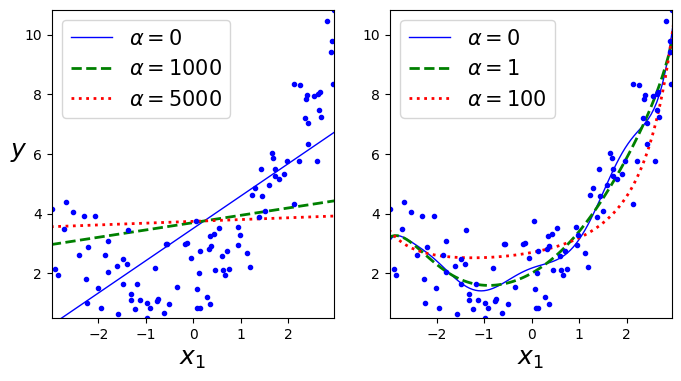

In [32]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),           # 표준화 축척 조정
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([X.min(), X.max(), y.min(), y.max()])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 1000, 5000), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 1, 100), random_state=42)

plt.show()

## 라쏘(Lasso, Least Absolute Shrinkage and Selector Operator) 회귀

라쏘(least absolute shrinkage and selection operator, Lasso) 회귀는 비용 함수($J(\theta)$)에 규제항($\alpha \overset{n}{\underset{i=1}{\Sigma}}|\theta_i|$, $l_1$ 노름)을 추가한다.  
$J(\theta) = MSE(\theta) + \alpha \overset{n}{\underset{i=1}{\Sigma}}|\theta_i|(= \alpha || \theta ||_1)$

여기서 Least Absolute Shrinkage는 변수의 중요성이 낮으면 0에 가깝게 만든다는 뜻이고 Selection Operator는 중요한 변수만 선택한다는 뜻이다.

라쏘 회귀의 특징

라쏘 회귀는 덜 중요한 특성의 가중치를 제거하려고 한다. 다른 말로 하면 라쏘 회귀는 자동으로 특성을 선택하고 희소 모델(특성의 가중치가 0인 경우 많음, 희소 행렬과 비슷)을 만든다.

서브그레이디언트 벡터

라쏘 회귀에서 $\ell_1$ 규제항의 그레이디언트는 $\theta > 0$일 때 1, $\theta < 0$일 때  -1, $\theta = 0$일 때 미분값이 존재하지 않는다.  
하지만, sign함수(규제항의 그레이디언트와 동일한데 $\theta = 0$일 때 미분값이 0)를 규제항의 그레이디언트 대신 사용하여 비용 함수(JR)의 그레이디언트를 계산할 수 있다.  
이러한 그레이디언트 벡터를 서브그레이디언트 벡터($g(\theta, J)$)라고 부른다.  
$g(\theta, J) = \nabla_\theta MSE(\theta) + \alpha \begin{pmatrix} sign(\theta_1) \\ sign(\theta_2) \\ \vdots \\ sign(\theta_n) \end{pmatrix}$

In [33]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.09481859])

라쏘 회귀로 규제한 $\alpha$에 따른 선형 회귀 모델, 다항 회귀 모델(사이킷런에서는 선형 회귀로 다항 회귀가 구현되므로 라쏘 회귀로 다항 회귀 규제 가능) 그래프

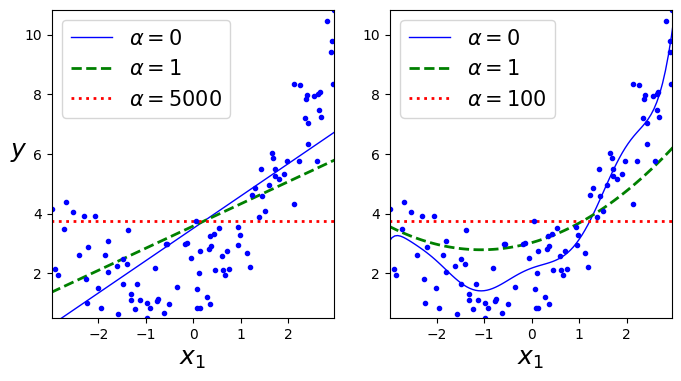

In [34]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 1, 5000), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1, 100), random_state=42)

plt.show()

아래는 L1 Norm, 라쏘 회귀, L2 Norm, 릿지 회귀에서 $\theta$가 어떻게 최적화되는지 보여준다.

아래에 있는 $\theta$가 어떻게 최적화되는지 보여주는 그래프를 보면 **라쏘 회귀**에서 $\theta_2$가 0으로 빠르게 줄어든다. 아마도 $\theta_2$가 덜 중요한 특성이라 빠르게 줄어드는 것 같다.

이 그래프에서 $\alpha$가 증가하면 전역 최적점(빨간 점)이 노란 점선을 따라 왼쪽으로 이동한다. $\alpha$가 증가하면 $\theta$가 0에 가까워지려고 하기 때문이다.  
또한, $\alpha$가 감소하면 전역 최적점(빨간 점)이 노란 점선을 따라 오른쪽으로 이동한다. $\alpha$가 감소할수록 라쏘 회귀의 비용 함수는 선형 회귀의 비용 함수와 비슷(JR가 MSE에 가까워진다)해지며 MSE일 때 $\theta$의 전역 최소값이 노란 점선의 맨 오른쪽 점이기 때문이다.

라쏘를 사용할 때 아래 그래프와 같이 진동하는 것을 막으려면 훈련하는 동안 점진적으로 학습률을 감소시켜야 한다.

릿지 회귀와 라쏘 회귀가 다른 점은 2가지이다.  
먼저 파라미터가 **전역 최적점에 가까울수록 그레이디언트가 작아진다**.  
또한, $\alpha$가 증가할수록 전역 최적점이 원점에 가까워지지만 **완전히 0이 되지는 않는다**.

라쏘 회귀와 릿지 회귀의 차이점

라쏘는 덜 중요한 특성이 빠르게 0에 가까워지지만, 릿지는 빠르게 0에 가까워지지 않을 뿐더러 0에 가까워지더라도 완전히 0이 되지는 않는다.  
학습률이 고정되어 있을 때, 라쏘는 전역 최적점에서 진동하지만, 릿지는 전역 최적점에 가까울수록 점진적으로 그레디언트가 작아진다(천천히 다가간다).

In [35]:
# 도표에 사용되는 좌표값 모음
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

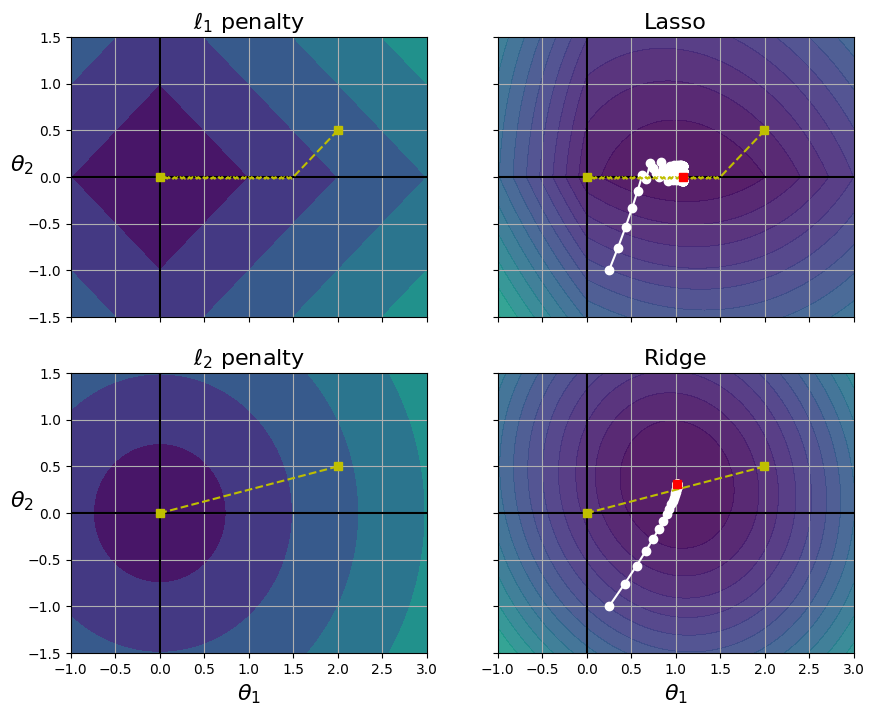

In [36]:
# 파라미터(theta) 경로 기억 어레이 생성 함수
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]
    
    # 좌측 도표 등고선 용도
    levelsN=np.linspace(0, np.max(N), 10)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    
    # 라쏘 또는 릿지 회귀 경사하강법 파라미터 경로
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    
    # l1 노름 또는 l2 노름 경사하강법 경로
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)
    
    # 좌측 도표(상단: 라쏘, 하단: 릿지)
    ax = axes[i, 0] 
    ax.grid(True)
    ax.axhline(y=0, color='k')                                     # x 축
    ax.axvline(x=0, color='k')                                     # y 축
    ax.contourf(t1, t2, N / 2., levels=levelsN)                    # 등고선
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")                     # 노랑 점선
    ax.plot(0, 0, "ys")                                            # 원점
    ax.plot(t1_min, t2_min, "ys")                                  # 좌표 (2, 1)
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    # 우측 도표(상단: 라쏘, 하단: 릿지)
    ax = axes[i, 1]   
    ax.grid(True)
    ax.axhline(y=0, color='k')                                      # x 축
    ax.axvline(x=0, color='k')                                      # y 축
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)             # 등고선
    
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")                    # 흰색 점실선
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")                      # 노랑 점선
    ax.plot(0, 0, "ys")                                             # 원점
    ax.plot(t1_min, t2_min, "ys")                                   # 좌표 (2, 1)
    ax.plot(t1r_min, t2r_min, "rs")                                 # 빨강 점
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

plt.show()

In [37]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.09481859])

## 엘라스틱넷

엘라스틱넷은 라쏘 회귀와 릿지 회귀의 규제항을 더한 것을 규제항으로 사용하는데, 혼합 비율 r로 혼합 정도를 조절한다. r = 0이면 엘라스틱 넷은 릿지 회귀와 같고, r = 1이면 라쏘 회귀와 같다.  
$J(\theta) = MSE(\theta) + r\alpha \overset{n}{\underset{i=1}{\Sigma}} |\theta_i| + (1-r) \alpha \frac{1}{2} \overset{n}{\underset{i=1}{\Sigma}} \theta_i^2$

선형 회귀, 릿지, 라쏘, 엘라스틱넷을 사용하는 시기

규제가 약간 있는 것이 좋으므로 일반적으로 선형 회귀는 피해야 한다.  
릿지 회귀를 기본으로 사용하지만 쓰이는 특성이 몇 개 뿐이라고 의심되면 라쏘나 엘라스틱넷이 낫다.  
하지만, 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 라쏘가 문제를 일으키므로 라쏘보다는 엘라스틱넷을 선호한다.

라쏘가 문제를 일으키는 이유

라쏘는 특성 수가 샘플 수(n)보다 많으면 최대 n개의 특성을 선택한다. 아마도 특성이 줄어들지 않을 수도 있다.  
또한, 여러 특성이 강하게 연관되어 있으면 이들 중 임의의 특성 하나를 선택한다. 임의로 특성을 선택하므로 아마도 더 중요한 특성을 놓칠 수 있다.

In [38]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.09373477])

## 조기 종료

경사 하강법과 같은 반복적인 학습 알고리즘을 규제하는 방법 중 하나는 검증 에러가 최소값에 도달하면 바로 훈련을 중지시키는 것이다. 이를 조기 종료(early stopping)이라고 한다.

In [39]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

# 5:5로 훈련/검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [40]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=1e-3, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

/opt/homebrew/Caskroom/miniforge/base/envs/handson2/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/handson2/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/handson2/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/handson2/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteratio

/opt/homebrew/Caskroom/miniforge/base/envs/handson2/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/handson2/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/handson2/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/handson2/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteratio

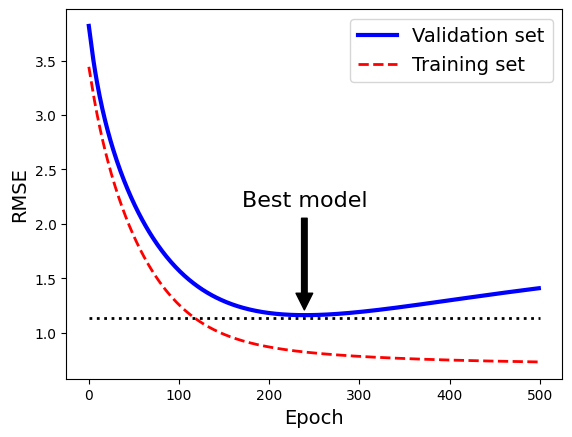

In [41]:
sgd_reg = SGDRegressor(max_iter=1, tol=1e-3, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500

train_errors, val_errors = [], []                    # 훈련/검증 모델 성능 기록 장치

for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)        # warm_start=True 이기에 학습결과를 이어감.
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))  # 훈련/검증모델 성능 기록
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)                  # 최고 성능의 모델 기억해두기
best_val_rmse = np.sqrt(val_errors[best_epoch])

# 아래부터는 그래프 그리는 코드임.

plt.annotate('Best model',                          # 도표에 문장 넣는 기능. 내용과 위치를 정확히 지정함.
             xy=(best_epoch, best_val_rmse),        # 색상, 폰트 크기 등등을 일일이 지정함.
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # 검정 실선을 잘 보여주기 위해서임.
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)  # 수평 검정 점선
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")    # 파랑 실선
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")   # 빵강 파선

# 기타 추가 정보
plt.legend(loc="upper right", fontsize=14)  # 범례
plt.xlabel("Epoch", fontsize=14)            # 축 정보
plt.ylabel("RMSE", fontsize=14)

plt.show()

확률적 경사 하강법과 미니 배치 경사 하강법에서 검증 에러의 최소값 찾기

배치 경사 하강법에 비해 확률적 경사 하강법이나 미니 배치 경사 하강법에서는 곡선이 매끄럽지 않아 최소값에 도달했는지 확인하기 어려울 수 있다.  
최소값에 도달했는지 확인하는 방법은 검증 에러가 일정 시간 동안 최소값보다 클 때(모델이 더 나아지지 않는다고 확신이 들 때) 학습을 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌리는 것이다.

# 로지스틱 회귀

로짓과 로지스틱 회귀

로지스틱 회귀는 로짓 회귀라고 부르기도 하는데 로짓을 입력으로 하는 로지스틱 함수를 비용 함수(로그 손실 = 교차 엔트로피)의 입력으로 사용하기 때문이다.

어떤 것을 양성으로 추정할 확률을 $p$라고 할 때, 음성으로 추정할 확률은 $1-p$이다. $odds$(오즈)는 $\frac {p} {1-p}$를 말한다. $log\ odds$(로그 오즈)는 $log(\frac {p} {1-p})$를 말하는데 이때 $log\ odds$는 줄여서 $logit$(로짓)이라고 부른다. 따라서 $logit$(로짓)은 '양성 확률 / 음성 확률'이라고 생각하면 된다. $logit$(로짓)을 다르게 생각해보면 $p$(양성 확률) 확률을 입력으로 받아서 $logit$(로짓, 양성 확률 / 음성 확률, $log(\frac {p} {1-p}))$을 출력하는 함수라고 생각하면 된다.  
  
$logit(p) = log(\frac {p} {1-p})$

Text(0.5, 1.0, 'logit')

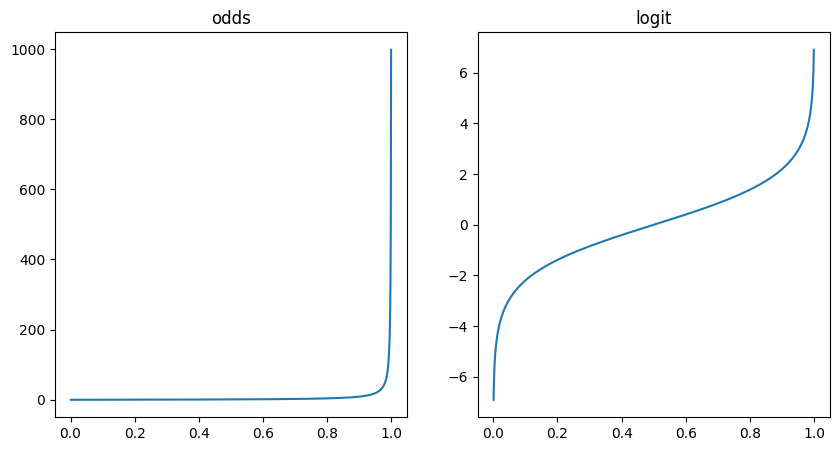

In [30]:
import numpy as np
import matplotlib.pyplot as plt

p = np.linspace(0, 1, 1000); p = np.delete(p, (0,-1))
odds = [_/(1-_) for _ in p]
logit = [np.log(_) for _ in odds]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(p, odds)
plt.title("odds")
plt.subplot(122)
plt.plot(p, logit)
plt.title("logit")

  
여기서, 로짓 함수의 역함수를 생각할 수 있는데, 이를 로지스틱(로짓의 역함수라고 해서 이름이 로지스틱이라고 붙여졌다)이라고 한다. 로지스틱 함수는 $logit$(로짓, 양성 확률 / 음성 확률, $log(\frac {p} {1-p})$)을 입력으로 받아서 $p$(양성 확률)을 출력하는 함수이다. 로지스틱 함수를 Sigmoid(시그모이드) 함수라고도 부르기도 한다.  
  
$logistic(L) = \frac {1} {1+e^{-L}}$

Text(0.5, 1.0, 'logistic')

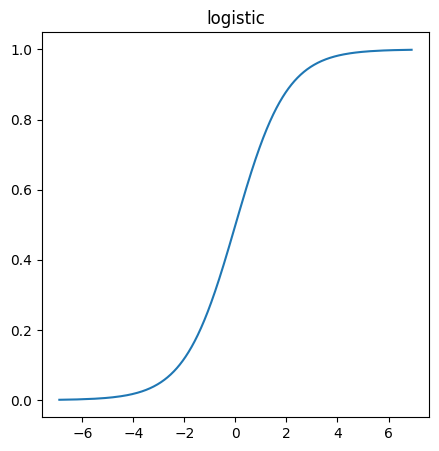

In [32]:
logistic = [1/(1+np.e**(-_)) for _ in logit]
plt.figure(figsize=(5, 5))
plt.plot(logit, logistic)
plt.title("logistic")

또한, $odds = \frac {p} {1-p}$ 이므로 $p \in (0, -1)$일 때 $odds \in (0, \infin)$이다. 따라서, $log\ odds = logit = log(odds) \in (-\infin, \infin)$


로지스틱 회귀 구조

로지스틱 회귀는 선형 회귀에 로지스틱 함수(= 시그모이드 함수) 붙여 만든다. 즉, 로지스틱 회귀는 선형 회귀 출력 값(추정된 로짓)의 로지스틱을 출력한다.  
  
또한, 로지스틱 회귀에 교차 엔트로피 함수를 사용하여 비용 함수를 계산한다. 이렇게 하면 비용 함수에 대한 가중치의 편미분 값을 얻을 수 있어, 경사하강법으로 학습이 가능하다.

여기서 선형 모델의 출력 값인 입력 특성에 가중치를 곱한 합($\theta^Tx$)를 추정된 로짓으로 사용할 것이기 때문에 로짓을 구하기 위해 로짓 함수를 직접적으로 사용하는 일은 없다. $\theta$ 값을 바꿔가며 선형 모델을 학습할수록 선형 모델은 로짓을 잘 추정할 것이다.

로지스틱 회귀 예측

어떤 회귀 알고리즘은 분류에서도 사용할 수 있다(마찬가지로 분류 알고리즘도 회귀에서 사용할 수 있다).  
  
로지스틱 회귀는 특정 클래스에 속할 확률을 추정하는데 추정 확률이 50% 초과라면 해당 클래스에 속한다고 예측(레이블이 '1'인 양성 클래스)한다. 50% 미만이면 해당 클래스에 속하지 않는다고 예측(레이블이 '2'인 음성 클래스)한다.  
  
이렇게 로지스틱 회귀는 회귀 알고리즘이지만 분류에서도 사용할 수 있고, 클래스 2개를 분류할 수 있으므로 이진 분류기이다.

로지스틱 회귀의 비용 함수(로그 함수, 교차 엔트로피 함수)

로지스틱 회귀의 비용 함수는 클래스 개수가 2개인 교차 엔트로피 함수이다.

음성 샘플의 확률을 0(음성 샘플 입장에서는 1)에 가깝게 추정한다면 비용은 0에 가까워지고, 1(음성 샘플 입장에서는 0)에 가깝게 추정한다면 비용은 무한으로 늘어난다.  
양성 샘플의 확률을 1에 가깝게 추정한다면 비용은 0에 가까워지고, 0에 가깝게 추정한다면 비용은 무한으로 늘어난다.  
  
비용 함수의 이러한 특징 때문에 로지스틱 모델을 학습할수록, 로지스틱 모델은 음성 샘플을 0에 가까운 확률로 추정하고, 양성 샘플을 1에 가까운 확률로 추정한다.

$J(\theta) = -\frac{1}{m}\overset{m}{\underset{i=1}{\Sigma}}[y^{(i)}log(\hat{p}^{(i)}) + (1-y^{(i)})log(1-\hat{p}^{(i)})]$

---

로지스틱 회귀의 비용 함수(로그 함수, 교차 엔트로피 함수)의 편미분

비용 함수에 대한 가중치의 편미분($\frac{\partial}{\partial\theta_j}J(\theta)$)은 $J(\theta)$에 연쇄법칙을 여러 번 사용하여 가중치로 편미분하면 된다.

$\frac{\partial}{\partial\theta_j}J(\theta) = \frac{1}{m}\overset{m}{\underset{i=1}{\Sigma}}(\sigma(\theta^Tx^{(i)})-y^{(i)})x_j^{(i)}$

$\frac{\partial}{\partial\theta_j}J(\theta)$이 존재하므로 경사하강법을 사용할 수 있고, 비용 함수는 가중치에 대해 convex 함수(지역 최소값이 없다)이므로 시간이 충분하고 학습 스케줄이 적절하다면 전역 최소값을 찾을 수 있다는 것을 보장한다.

결정 경계

특성을 1개 사용하는 로지스틱 회귀에서 결정 경계는 양성 확률이 0.5가 되는 꽃잎 너비의 길이가 결정 경계가 된다. 이 경우 결정 경계보다 크면 양성, 작으면 음성이다.  
특성을 2개 사용하는 로지스틱 회귀에서 결정 경계는 양성 확률이 0.5가 되는 특성 2개를 종속변수, 독립변수로 하는 2차원 직선이다.

로지스틱 회귀에서 결정 경계는 선형 모델의 출력값인 로짓이 0(로짓이 0일때 양성 확률이 0.5가 되므로)이 되는 점들의 모임이다.

In [39]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(np.int32) # 버지니카(Virginica) 품종일 때 1(양성), 아니면 0(음성)

In [40]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

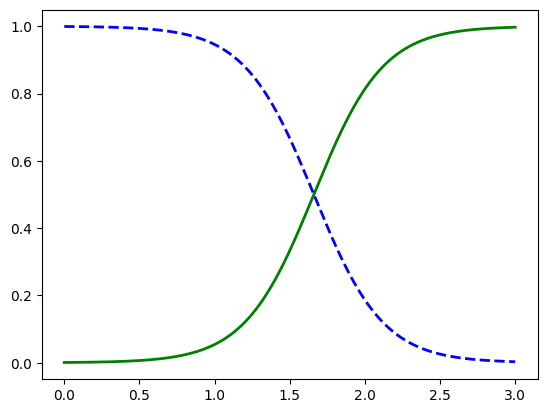

In [41]:
X_new = np.linspace(0, 3, 1000).reshape(1000, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

# 소프트맥스 회귀

로지스틱 회귀 모델과 소프트맥스 회귀 모델

로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화할 수 있다. 이를 소프트맥스 회귀라고 부른다.  

이진 분류기로써 로지스틱 회귀 모델과 소프트맥스 회귀는 활성화 함수가 서로 다르다. 로지스틱 회귀 모델은 로지스틱 함수(시그모이드 함수), 소프트맥스 회귀 모델은 소프트맥스 함수(정규화된 지수 함수, normalized exponential function)를 활성화 함수로 사용한다.  
  
소프트맥스 함수가 로지스틱 함수의 역할을 한다. 즉, 소프트맥스 함수는 (점수라고도 불리고 클래스마다 존재하는 )로짓을 입력으로 받아 확률로 출력한다.

k 클래스 추정 확률 $\hat{p}_k = \sigma(s(x))_k = \frac{exp(s_k(x))}{\overset{K}{\underset{j=1}{\Sigma}}exp(s_j(x))}$, 여기서 $\sigma$는 소프트맥스 함수, $s(x)$는 모든 $s_j(x)$ 점수가 있는 벡터, $s_j(x)$는 j 클래스 점수

---

소프트맥스 회귀 분류기의 예측

소프트맥스 회귀 분류기는 로지스틱 회귀 분류기와 마찬가지로 추정 확률이 가장 높은 클래스를 선택한다.

추정 클래스 $\hat{y} = \underset{k}{argmax\ \sigma(s(x))_k} = \underset{k}{argmax\ s_k(x)} = \underset{k}{argmax((\theta^{(k)})^Tx)} $  
소프트맥스 함수 특성 때문에 등호가 성립됨.

> 참고로, 소프트맥스 회귀는 다중 클래스이지 다중 출력은 아님

---

소프트맥스의 비용 함수(로그 손실, 교차 엔트로피 함수)

로지스틱 회귀도 마찬가지지만 소프트맥스 회귀의 비용 함수는 정답 클래스의 추정 확률이 낮을수록 비용이 점점 더 커지도록(최대 무한), 추정 확률이 높을수록 비용이 점점 더 작아지도록(최소 0) 설계되었다.  
  
따라서, 비용 함수가 더 줄어든다는 것은 학습되어 정답 클래스의 추정 확률이 더 높아진다는 것을 의미한다.

$J(\Theta) = -\frac{1}{m}\overset{m}{\underset{i=1}{\Sigma}}\overset{K}{\underset{k=1}{\Sigma}}y^{(i)}_klog(\hat{p}^{(i)}_k)$

여기서 정답 클래스는 원-핫 인코딩되어 K 개의 원소를 가지고, 1이 하나이며 나머지는 0인 벡터로 변형되어야 한다.

---

소프트맥스의 비용 함수(로그 손실, 교차 엔트로피 함수)의 그레이디언트 백터

$\nabla_{\theta^{(k)}}J(\Theta) = \frac {1}{m} \overset{m}{\underset{i=1}{\Sigma}}(\hat{p}_k^{(i)} - y_k^{(i)})x^{(i)}$

이 편도함수도 연쇄법칙을 여러 번 적용하면 구할 수 있다.

앞서 말한 것처럼 $\nabla_{\theta^{(k)}}J(\Theta)$가 존재하므로 경사하강법으로 학습할 수 있다.

---

소프트맥스 회귀 예시

여기서 $C$는 $\frac{1}{\alpha}$로 규제 정도를 조절하는 값이다. 로지스틱 회귀와 소프트맥스 회귀를 규제할 때 모두 $C$를 사용한다.  
$C$가 더 커진다면 $\alpha$가 더 작아지므로 규제가 완화되고, $C$가 더 작아진다면 $\alpha$가 더 커지므로 규제가 강화된다.

In [46]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/handson2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [47]:
softmax_reg.predict([[5, 2]])

array([2])

In [48]:
softmax_reg.predict_proba([[5, 2]])

array([[6.21626375e-07, 5.73689803e-02, 9.42630398e-01]])

결정 경계

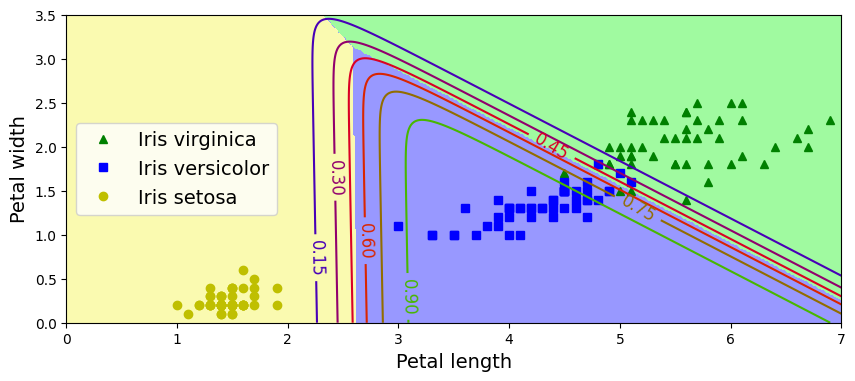

In [47]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])

plt.show()